# Install Dependency

In [ ]:
# pip install scikit-learn

In [ ]:
# pip install matplotlib

In [ ]:
# pip install tensorboard

In [ ]:
# pip install tqdm

In [ ]:
# pip install transformers

In [ ]:
# pip install torchcam


In [ ]:
# pip install shap

In [ ]:
# pip install lime scikit-image

In [ ]:
# pip install grad-cam

In [ ]:
# pip install captum

# Dataset preaparing

In [1]:
import os
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to dataset folders
ddiabetic_folder = r"D:\Data\NYC\Retina\Data\Diabetic"
normal_folder = r"D:\Data\NYC\Retina\Data\Diabetic\Normal"

# Transformations for training data (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transformations for validation and test data (without augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Combine both folders into a single dataset
dataset = datasets.ImageFolder(
    root=r"D:\Data\NYC\Retina\Data"
)

# Explicitly verify class names and indices
print(f"Class to index mapping: {dataset.class_to_idx}")

# Splitting indices for train, validation, and test sets
train_idx, temp_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.3,  # 30% for validation and test
    stratify=dataset.targets,  # Maintain class balance
    random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,  # Split remaining 30% equally into validation and test
    stratify=[dataset.targets[i] for i in temp_idx],  # Maintain class balance
    random_state=42
)

# Create subsets for DataLoader
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Apply transformations to subsets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Verify dataset sizes
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")


Using device: cuda
Class to index mapping: {'Diabetic': 0, 'Normal': 1}
Total images: 11156
Training images: 7809
Validation images: 1673
Test images: 1674


# Parameter Setup

In [2]:
GLOBAL_EPOCH = 250          # or whatever value you want
GLOBAL_Lr = 5e-4           # or any learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eva_type = "full"          # (example) naming the evaluation file

# Training Function

In [3]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter  # For logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.cuda.amp as amp  # For mixed precision training

def train_model(model, train_loader, val_loader, num_epochs, lr=0.001, wd=1e-4,
                log_dir="./logs", save_path="best_model.pth", patience=5,
                use_scheduler=True, use_mixed_precision=False):
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()  # For binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    writer = SummaryWriter(log_dir=log_dir)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    scaler = amp.GradScaler() if use_mixed_precision else None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()

            with amp.autocast(enabled=use_mixed_precision):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            if use_mixed_precision:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        # Save best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Validation loss improved. Model weights saved!")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s).")

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if use_scheduler:
            scheduler.step(val_loss)

        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs! Best Val Loss: {best_val_loss:.4f}")
            break

    print("Training Complete!")

    # Plotting
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluation Function

In [4]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # <-- For saving CSV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm.auto import tqdm  # <-- Smoother tqdm for all environments (optional but better)

def evaluate_model(model, test_loader, criterion, model_name,
                   checkpoint_path=None, output_file="evaluation_results.txt",
                   save_dir="./results"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If checkpoint is provided, load it
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        print(f"Loading best model from {checkpoint_path}...")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))

    model = model.to(device)
    model.eval()

    os.makedirs(save_dir, exist_ok=True)

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            inputs, labels = inputs.to(device), labels.float().to(device)

            if labels.ndim == 1:
                labels = labels.unsqueeze(1)

            outputs = model(inputs)

            # Handle output if model outputs a dict (like ViT sometimes)
            if isinstance(outputs, dict) and "logits" in outputs:
                outputs = outputs["logits"]

            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = test_correct / test_total

    # Explicit class names + class order handling
    class_names = ['Diabetic', 'Normal']
    class_labels = [0, 1]

    # Ensure labels and preds are flattened properly
    all_labels = [int(x[0]) for x in all_labels]  # Flatten nested arrays
    all_preds = [int(x[0]) for x in all_preds]

    # Classification report (handle missing classes safely)
    report = classification_report(
        all_labels, all_preds,
        labels=class_labels,
        target_names=class_names,
        zero_division=0
    )

    # Confusion matrix (explicit label order)
    cm = confusion_matrix(
        all_labels, all_preds,
        labels=class_labels
    )

    # Save text results
    output_path = os.path.join(save_dir, output_file)
    with open(output_path, "w") as f:
        results = (
            f"Model: {model_name}\n"
            f"Test Loss: {test_loss:.4f}\n"
            f"Test Accuracy: {test_accuracy:.4f}\n"
            f"Classification Report:\n{report}\n"
            f"Confusion Matrix:\n{cm}\n"
            "----------------------------------------\n"
        )
        print(results)
        f.write(results)

    # -------- Confusion Matrix Plot --------
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    cm_save_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_save_path)
    plt.show()
    plt.close()

    # Optional: Save Confusion Matrix as CSV
    # cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    # cm_csv_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.csv")
    # cm_df.to_csv(cm_csv_path)


    # -------- ROC Curve --------
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    roc_save_path = os.path.join(save_dir, f"{model_name}_roc_curve.png")
    plt.savefig(roc_save_path)
    plt.show()
    plt.close()

    # Optional: Save ROC Curve data as CSV
    # roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr})
    # roc_csv_path = os.path.join(save_dir, f"{model_name}_roc_curve.csv")
    # roc_df.to_csv(roc_csv_path, index=False)

    return test_loss, test_accuracy

## EfficientNet-B0 + DenseNet121

c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also us


Epoch 1/250


Training:   0%|          | 0/62 [00:11<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_31124\1156069080.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=use_mixed_precision):


Validation:   0%|          | 0/14 [00:10<?, ?it/s]

Validation loss improved. Model weights saved!
Epoch 1/250 | Train Loss: 0.4694, Train Acc: 0.7453 | Val Loss: 0.4502, Val Acc: 0.7418

Epoch 2/250


Training:   0%|          | 0/62 [00:10<?, ?it/s]

Validation:   0%|          | 0/14 [00:10<?, ?it/s]

Validation loss improved. Model weights saved!
Epoch 2/250 | Train Loss: 0.3679, Train Acc: 0.8155 | Val Loss: 0.4338, Val Acc: 0.7788

Epoch 3/250


Training:   0%|          | 0/62 [00:12<?, ?it/s]

Validation:   0%|          | 0/14 [00:12<?, ?it/s]

No improvement in validation loss for 1 epoch(s).
Epoch 3/250 | Train Loss: 0.3288, Train Acc: 0.8445 | Val Loss: 0.4578, Val Acc: 0.7782

Epoch 4/250


Training:   0%|          | 0/62 [00:10<?, ?it/s]

Validation:   0%|          | 0/14 [00:10<?, ?it/s]

No improvement in validation loss for 2 epoch(s).
Epoch 4/250 | Train Loss: 0.2644, Train Acc: 0.8794 | Val Loss: 0.5821, Val Acc: 0.7968

Epoch 5/250


Training:   0%|          | 0/62 [00:10<?, ?it/s]

Validation:   0%|          | 0/14 [00:10<?, ?it/s]

No improvement in validation loss for 3 epoch(s).
Epoch 5/250 | Train Loss: 0.2028, Train Acc: 0.9133 | Val Loss: 0.4818, Val Acc: 0.7938

Epoch 6/250


Training:   0%|          | 0/62 [00:10<?, ?it/s]

Validation:   0%|          | 0/14 [00:10<?, ?it/s]

No improvement in validation loss for 4 epoch(s).
Epoch 6/250 | Train Loss: 0.1717, Train Acc: 0.9333 | Val Loss: 0.5861, Val Acc: 0.7800

Epoch 7/250


Training:   0%|          | 0/62 [00:10<?, ?it/s]

Validation:   0%|          | 0/14 [00:10<?, ?it/s]

No improvement in validation loss for 5 epoch(s).
Epoch 7/250 | Train Loss: 0.0841, Train Acc: 0.9682 | Val Loss: 0.6457, Val Acc: 0.7986

Early stopping triggered after 7 epochs! Best Val Loss: 0.4338
Training Complete!


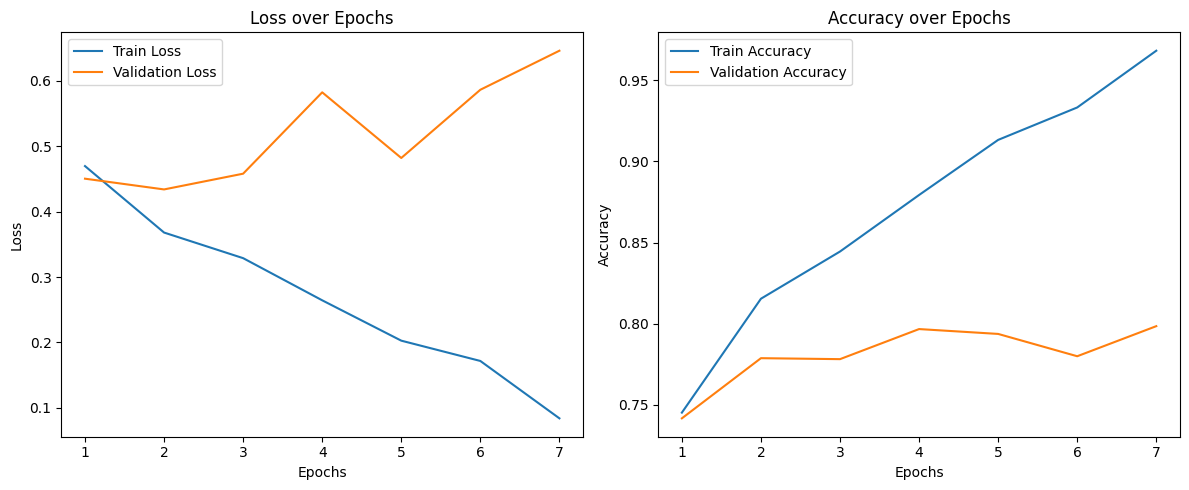

Evaluating fusion_model:   0%|          | 0/14 [00:10<?, ?it/s]

Model: fusion_model
Test Loss: 0.4194
Test Accuracy: 0.7861
Classification Report:
              precision    recall  f1-score   support

    Diabetic       0.87      0.68      0.76       837
      Normal       0.73      0.90      0.81       837

    accuracy                           0.79      1674
   macro avg       0.80      0.79      0.78      1674
weighted avg       0.80      0.79      0.78      1674

Confusion Matrix:
[[566 271]
 [ 87 750]]
----------------------------------------



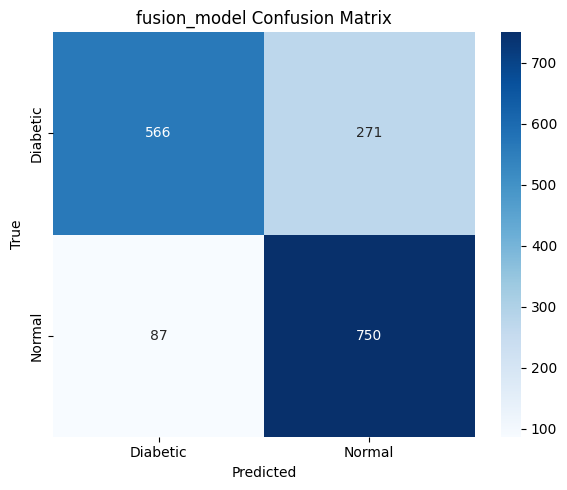

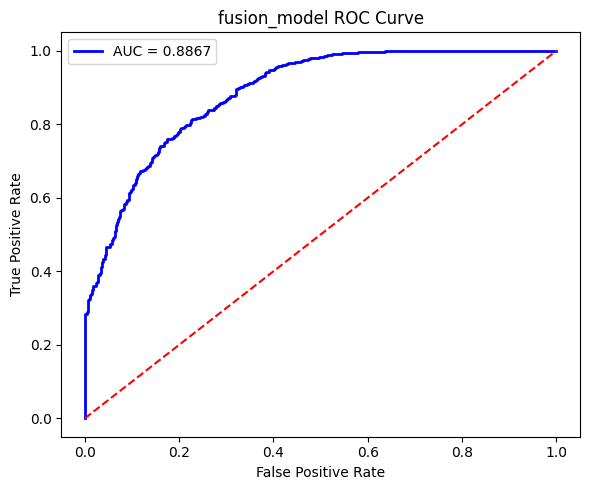

8855

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models
import gc

# ------------------------ Fusion Model Definition with Dimensionality Reduction ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):  # Added parameter for DR output dimension
        super(FusionModelWithDR, self).__init__()

        # Removed ResNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 1280 + 1024  # Only EfficientNet + DenseNet

        # Dimensionality Reduction layer
        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.dr_out_dim = dr_out_dim

        self.fusion_head = nn.Sequential(
            nn.Linear(self.dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # No sigmoid
        )

    def forward(self, x):
        f1 = self.efficientnet(x)
        f2 = self.densenet(x)

        combined = torch.cat([f1, f2], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)

# ------------------------ Instantiate and Move to Device ------------------------
# New total fusion input = 1280 (EfficientNet) + 1024 (DenseNet) = 2304
dr_output_dimension = 1536  # You can reduce this as needed
fusion_model = FusionModelWithDR(dr_out_dim=dr_output_dimension).to("cuda" if torch.cuda.is_available() else "cpu")

save_path = "fusion_best_model.pth"
log_dir = "./logs/fusion"

train_model(
    model=fusion_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=GLOBAL_EPOCH,
    lr=GLOBAL_Lr,
    wd=1e-4,
    log_dir=log_dir,
    save_path=save_path,
    patience=5,                 # Early stopping patience
    use_scheduler=True,         # Enable ReduceLROnPlateau
    use_mixed_precision=True    # AMP for faster training
)

# ------------------------ Load the Best Model ------------------------
fusion_model.load_state_dict(torch.load(save_path))  # Load best checkpoint

# ------------------------ Evaluation ------------------------
evaluate_model(
    model=fusion_model,
    test_loader=test_loader,
    criterion=nn.BCEWithLogitsLoss(),  # Important: BCEWithLogitsLoss
    model_name="fusion_model",
    output_file="evaluation_results.txt",  # Save evaluation text
    save_dir="./results/fusion"            # Save confusion matrix, ROC curve
)

# ------------------------ Cleanup ------------------------
del fusion_model
torch.cuda.empty_cache()
gc.collect()




# Interpretability

## Grad-CAM

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import gc

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# ------------------------ Define Your Fusion Model ------------------------
class FusionModelWithDR(nn.Module):
    def __init__(self, dr_out_dim=512):  # Added parameter for DR output dimension
        super(FusionModelWithDR, self).__init__()

        # Removed ResNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Identity()

        self.fusion_input_dim = 1280 + 1024  # Only EfficientNet + DenseNet

        # Dimensionality Reduction layer
        self.dr = nn.Linear(self.fusion_input_dim, dr_out_dim)
        self.dr_out_dim = dr_out_dim

        self.fusion_head = nn.Sequential(
            nn.Linear(self.dr_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # No sigmoid
        )

    def forward(self, x):
        f1 = self.efficientnet(x)
        f2 = self.densenet(x)

        combined = torch.cat([f1, f2], dim=1)
        reduced_features = self.dr(combined)
        return self.fusion_head(reduced_features)


# ------------------------ Load Model and Weights ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion_model_dr = FusionModelWithDR(dr_out_dim=1152).to(device)

# Path to your trained model weights
model_path = r"C:\Users\user\Documents\GitHub\NYC_Research_Cell\RETINA\Office\fusion_best_model.pth"
fusion_model_dr.load_state_dict(torch.load(model_path, map_location=device))
fusion_model.eval()

# ------------------------ Preprocessing ------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------ Target Layers ------------------------
target_layers = {
    "resnet50": fusion_model_dr.resnet.layer4,
    "efficientnet_b0": fusion_model_dr.efficientnet.features[-1],
    "densenet121": fusion_model_dr.densenet.features[-1]
}

# ------------------------ Visualization Function ------------------------
def visualize_and_save(cam, orig_img, save_path, title):
    """Overlay CAM and save"""
    orig_img_resized = orig_img.resize((224, 224))

    # Normalize cam to [0, 255]
    cam_img = cam.squeeze(0).numpy()
    cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min() + 1e-8)
    cam_img = np.uint8(255 * cam_img)

    # Convert to PIL grayscale image
    cam_pil = Image.fromarray(cam_img).convert("L")

    # Overlay heatmap on original image
    heatmap = overlay_mask(orig_img_resized, cam_pil, alpha=0.6)

    plt.figure(figsize=(6,6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

# ------------------------ Batch Grad-CAM Loop ------------------------

# Your folder of test images
img_dir =  r"D:\Data\NYC\Retina\Data\Diabetic" # CHANGE THIS PATH
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Output dir
os.makedirs("./gradcam_results_batch", exist_ok=True)

for img_path in img_paths:
    pil_img = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

    # Store CAMs for this image
    cams = {}

    for name, layer in target_layers.items():
        cam_extractor = GradCAM(model=fusion_model_dr, target_layer=layer)

        # Forward pass
        out = fusion_model_dr(input_tensor)

        # Binary classifier → class_idx = 0
        activation_map = cam_extractor(0, out)

        # Store CAM
        cams[name] = activation_map[0].detach().cpu()

    # Save CAMs
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    for name, cam in cams.items():
        save_path = f"./gradcam_results_batch/{img_filename}_{name}_gradcam.png"
        visualize_and_save(cam, pil_img, save_path, f"{name.upper()} Grad-CAM")
        print(f"✅ Saved Grad-CAM for {img_filename} - {name} at {save_path}")

# ------------------------ Cleanup ------------------------
del fusion_model_dr
torch.cuda.empty_cache()
gc.collect()

c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also us

RuntimeError: Error(s) in loading state_dict for FusionModelWithDR:
	size mismatch for dr.weight: copying a param with shape torch.Size([1536, 2304]) from checkpoint, the shape in current model is torch.Size([1152, 2304]).
	size mismatch for dr.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for fusion_head.0.weight: copying a param with shape torch.Size([512, 1536]) from checkpoint, the shape in current model is torch.Size([512, 1152]).

In [8]:
!pip install torchcam


## LIME

C:\Users\rafid\AppData\Local\Temp\ipykernel_32224\1417089756.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load("fusion_model_dr

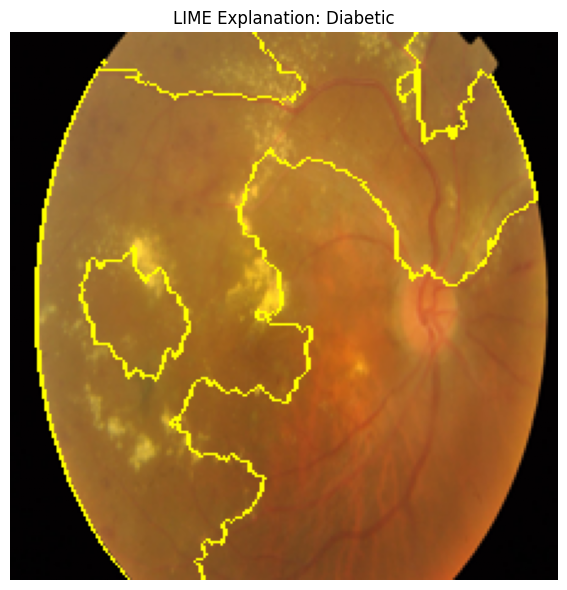

In [ ]:
import torch
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torchvision import models
from skimage.color import label2rgb

# -------------------- Device and Model Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained fusion model
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2-res.pth", map_location=device))
fusion_model_dr.eval().to(device)

# -------------------- Define Prediction Function --------------------
def predict_fn(images_np):
    """
    Takes a batch of images in numpy format (HWC, values in [0, 1]),
    normalizes and returns probabilities in the order: [Diabetic (0), Normal (1)].
    """
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    tensor_batch = torch.stack([
        preprocess((img * 255).astype(np.uint8)) for img in images_np
    ])
    tensor_batch = tensor_batch.to(device)

    with torch.no_grad():
        logits = fusion_model_dr(tensor_batch).squeeze(1)  # [batch]
        probs_normal = torch.sigmoid(logits).cpu().numpy()  # Probabilities for class 1 (Normal)
        probs_diabetic = 1 - probs_normal  # Invert for Diabetic class (0)

    # Return [Diabetic, Normal]
    return np.stack([probs_diabetic, probs_normal], axis=1)

# -------------------- Load and Preprocess Image --------------------
image_path = "APTOS_D_0c917c372572.png"  # Replace with your image
original_image = Image.open(image_path).convert("RGB").resize((224, 224))
image_np = np.array(original_image) / 255.0  # Normalize to [0, 1]

# -------------------- LIME Explanation --------------------
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image_np,
    classifier_fn=predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000  # More samples → more stable explanation
)

from skimage.segmentation import mark_boundaries

# -------------------- Get LIME mask and temp image --------------------
label_to_show = 0  # 0 = Diabetic

temp, mask = explanation.get_image_and_mask(
    label=label_to_show,
    positive_only=True,     # Only show features supporting the prediction
    num_features=10,        # More superpixels = more interpretability
    hide_rest=False         # Set to False to show the whole image
)

# -------------------- Fix visualization issue --------------------
# If temp looks black, normalize to [0, 1] or ensure dtype is correct
if temp.dtype != np.uint8:
    temp = (temp * 255).astype(np.uint8)

# Display overlay
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation: {'Diabetic' if label_to_show == 0 else 'Normal'}")
plt.axis("off")
plt.tight_layout()
plt.savefig("lime_fusion_diabetic_explanation.png")
plt.show()



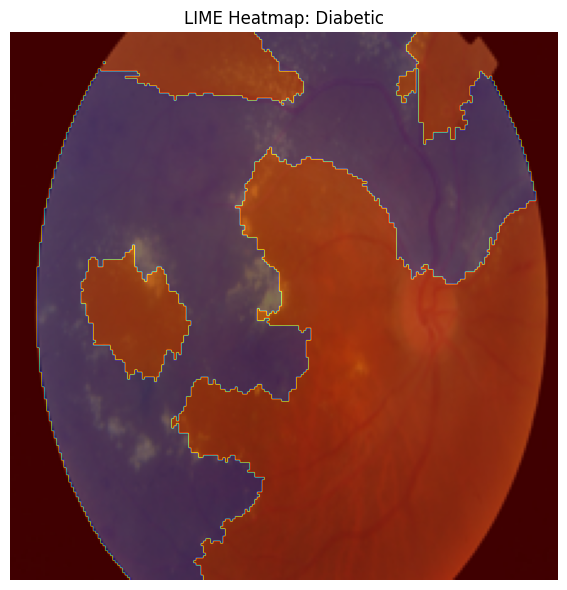

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import numpy as np

# -------------------- Get the mask and scores --------------------
label_to_show = 0  # 0 = Diabetic

# Get LIME explanation
temp, mask = explanation.get_image_and_mask(
    label=label_to_show,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Get image + superpixel weights as a dict: {segment_id: importance_score}
dict_heatmap = dict(explanation.local_exp[label_to_show])  # {superpixel_index: weight}

# Create an empty heatmap and fill with importance values
heatmap = np.zeros(mask.shape, dtype=np.float32)
for seg_val, score in dict_heatmap.items():
    heatmap[mask == seg_val] = score

# Normalize heatmap to [0, 1]
heatmap -= heatmap.min()
heatmap /= (heatmap.max() + 1e-6)

# Resize original image (just to make sure it's uint8)
original_display = (image_np * 255).astype(np.uint8)

# Overlay heatmap on original image using alpha blending
plt.figure(figsize=(6, 6))
plt.imshow(original_display)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Heatmap overlay
plt.title(f"LIME Heatmap: {'Diabetic' if label_to_show == 0 else 'Normal'}")
plt.axis("off")
plt.tight_layout()
plt.savefig("lime_heatmap_diabetic.png")
plt.show()


In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# -------------------- Paths --------------------
input_folder = "images/"
output_folder = "lime_heatmaps/"
os.makedirs(output_folder, exist_ok=True)

# -------------------- Device and Model --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2-res.pth", map_location=device))
fusion_model_dr.eval().to(device)

# -------------------- Prediction Function for LIME --------------------
def predict_fn(images_np):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    tensor_batch = torch.stack([
        preprocess((img * 255).astype(np.uint8)) for img in images_np
    ])
    tensor_batch = tensor_batch.to(device)

    with torch.no_grad():
        logits = fusion_model_dr(tensor_batch).squeeze(1)
        probs_normal = torch.sigmoid(logits).cpu().numpy()
        probs_diabetic = 1 - probs_normal

    return np.stack([probs_diabetic, probs_normal], axis=1)

# -------------------- LIME Explainer --------------------
explainer = lime_image.LimeImageExplainer()

# -------------------- Process All Images --------------------
for filename in os.listdir(input_folder):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    image_path = os.path.join(input_folder, filename)
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    image_np = np.array(image) / 255.0

    # Get LIME explanation
    explanation = explainer.explain_instance(
        image_np,
        classifier_fn=predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    label_to_show = 0  # 0 = Diabetic
    temp, mask = explanation.get_image_and_mask(
        label=label_to_show,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Build heatmap
    dict_heatmap = dict(explanation.local_exp[label_to_show])
    heatmap = np.zeros(mask.shape, dtype=np.float32)
    for seg_val, score in dict_heatmap.items():
        heatmap[mask == seg_val] = score
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-6)

    # Overlay heatmap
    original_display = (image_np * 255).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(original_display)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"{filename} - LIME Heatmap (Diabetic)")
    plt.axis("off")
    plt.tight_layout()

    # Save output
    output_path = os.path.join(output_folder, f"lime_{filename}")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    plt.close()

    print(f"Saved: {output_path}")


C:\Users\rafid\AppData\Local\Temp\ipykernel_32224\3368844748.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load("fusion_model_dr

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'images/'

## SHAP

In [ ]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# -------------------- Device Setup --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Preprocessing --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------- Load Trained Fusion Model --------------------
# Make sure your model is defined exactly as in training before loading state dict
fusion_model_dr.eval()
fusion_model_dr.to(device)
fusion_model_dr.load_state_dict(torch.load("fusion_model_dr_best_phase2.pth", map_location=device))

# -------------------- Prepare Background Dataset --------------------
# Replace with 5 real image paths from your dataset (can be both Normal and Diabetic)
background_paths = ["APTOS_D_000c1434d8d7.png", "APTOS_D_00a8624548a9.png", "APTOS_D_00b74780d31d.png", "APTOS_N_00cc2b75cddd.png", "APTOS_N_00f6c1be5a33.png"]
background_images = []

for path in background_paths:
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img)
    background_images.append(img_tensor)

background_tensor = torch.stack(background_images).to(device)  # Shape: [5, 3, 224, 224]

# -------------------- SHAP Wrapper --------------------
def shap_model_wrapper(x):
    """
    SHAP-compatible wrapper that returns class probabilities:
    Index 0 = Diabetic (class 0)
    Index 1 = Normal   (class 1)
    """
    x = x.to(device)
    with torch.no_grad():
        logits = fusion_model_dr(x).squeeze(1)  # [batch]
        probs = torch.sigmoid(logits)
        probs_diabetic = 1 - probs
        probs_normal = probs
        return torch.stack([probs_diabetic, probs_normal], dim=1).cpu().numpy()  # [batch, 2]

# -------------------- Initialize SHAP Explainer --------------------
explainer = shap.DeepExplainer(shap_model_wrapper, background_tensor)

# -------------------- Load Test Image --------------------
img_path = "DR.jpg"  # Replace with path to image to explain
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]

# -------------------- SHAP Explanation --------------------
shap_values = explainer.shap_values(img_tensor)

# -------------------- Visualize SHAP Heatmap --------------------
# SHAP expects input in [H, W, C] format in range [0, 1]
input_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_np = np.clip(input_np, 0, 1)  # Ensure it's in [0,1]

# Plot SHAP heatmap
shap.image_plot(shap_values, [input_np])



C:\Users\rafid\AppData\Local\Temp\ipykernel_16860\3474571393.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_model_dr.load_state_dict(torch.load("fusion_model_dr

ModuleNotFoundError: No module named 'tensorflow'